# Part 1

### Numpy

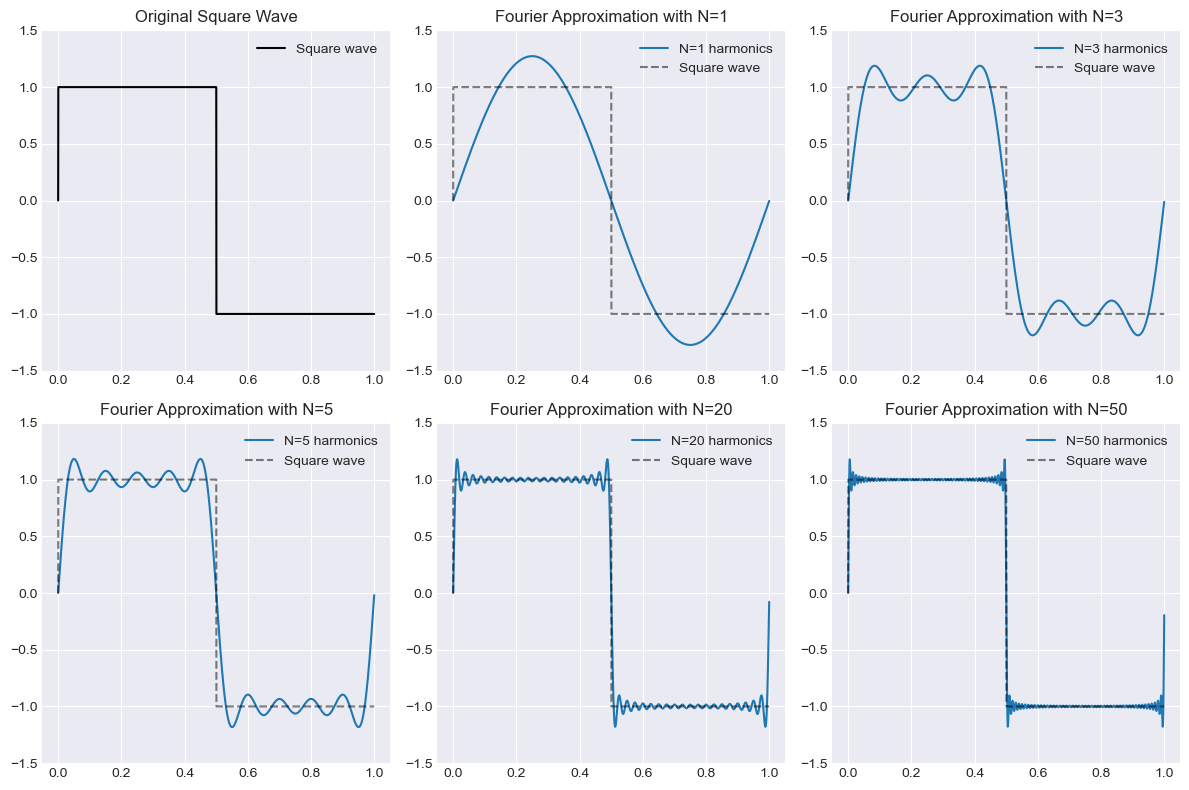

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Set parameters for the signal
N = 2048 # Number of sample points
T = 1.0 # Duration of the signal in seconds
f0 = 1 # Fundamental frequency of the square wave in Hz

# List of harmonic numbers used to construct the square wave
harmonics = [1, 3, 5, 20, 50]

# Define the square wave function
def square_wave(t):
    return np.sign(np.sin(2.0 * np.pi * f0 * t))

# Fourier series approximation of the square wave
def square_wave_fourier(t, f0, N):
    result = np.zeros_like(t)
    for k in range(N):
        # The Fourier series of a square wave contains only odd harmonics.
        n = 2 * k + 1
        # Add harmonics to reconstruct the square wave.
        result += np.sin(2 * np.pi * n * f0 * t) / n
    # (the sum of the series is pi/4)
    return (4 / np.pi) * result

# Create the time vector
# np.linspace generates evenly spaced numbers over a specified interval.
# We use endpoint=False because the interval is periodic.
t = np.linspace(0.0, T, N, endpoint=False)

# Generate the original square wave
square = square_wave(t)
plt.figure(figsize=(12, 8))

# Plot the original square wave
plt.subplot(2, 3, 1)
plt.plot(t, square, 'k', label="Square wave")
plt.title("Original Square Wave")
plt.ylim(-1.5, 1.5)
plt.grid(True)
plt.legend()

# Plot Fourier reconstructions under different number of harmonics
for i, Nh in enumerate(harmonics, start=2):
    plt.subplot(2, 3, i)
    y = square_wave_fourier(t, f0, Nh)
    plt.plot(t, y, label=f"N={Nh} harmonics")
    plt.plot(t, square, 'k--', alpha=0.5, label="Square wave")
    plt.title(f"Fourier Approximation with N={Nh}")
    plt.ylim(-1.5, 1.5)
    plt.grid(True)
    plt.legend()
plt.tight_layout()
plt.show()

--- DFT/FFT Performance Comparison ---
Naïve DFT Execution Time: 3.210750 seconds
NumPy FFT Execution Time: 0.000219 seconds
FFT is approximately 14669.78 times faster.

Our DFT implementation is close to NumPy's FFT: True


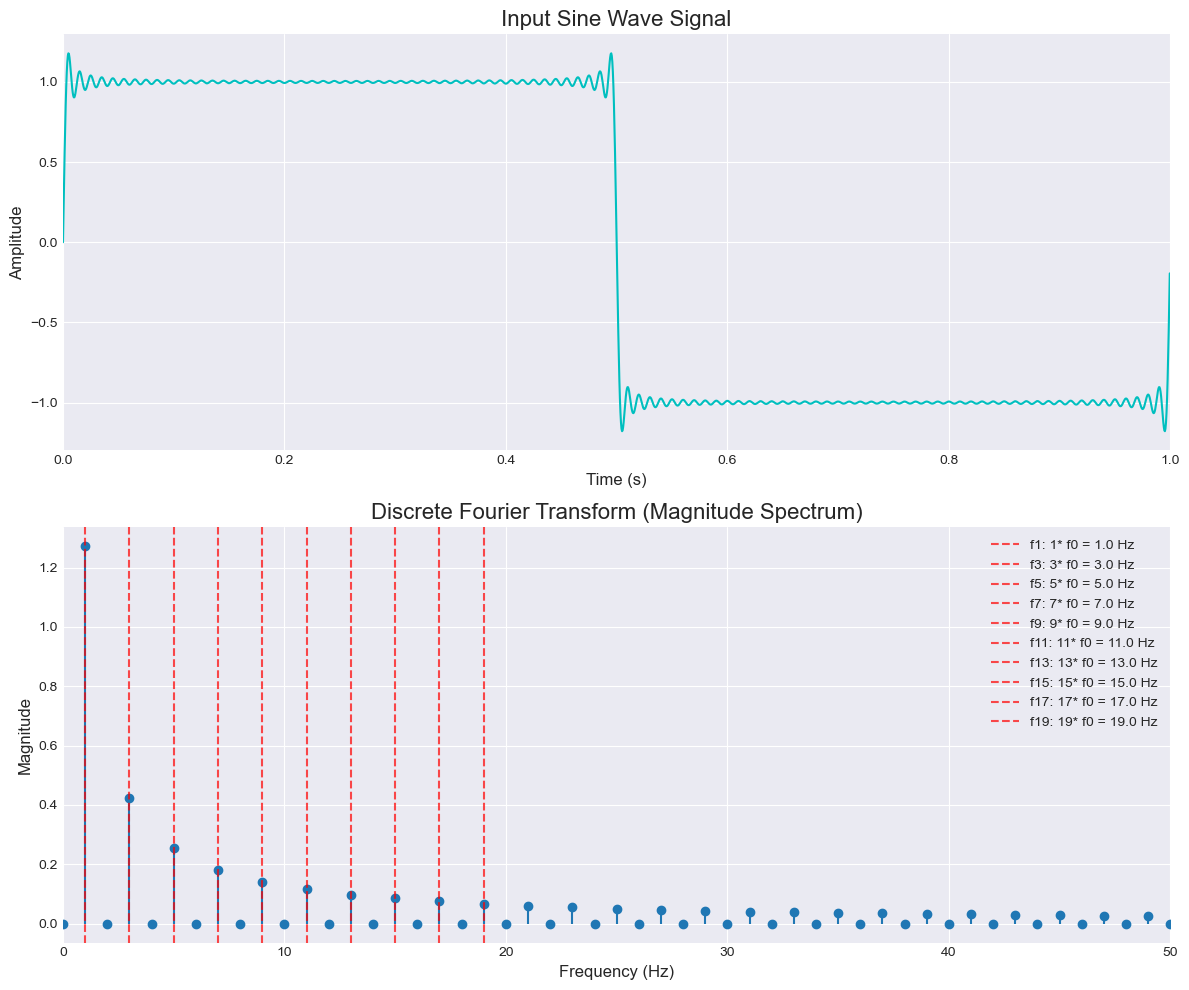

In [12]:
def naive_dft(x):
    """
    Compute the Discrete Fourier Transform (DFT) of a 1D signal.
    This is a "naïve" implementation that directly follows the DFT formula,
    which has a time complexity of O(N^2).
    Args:
    x (np.ndarray): The input signal, a 1D NumPy array.
    Returns:
    np.ndarray: The complex-valued DFT of the input signal.
    """
    N = len(x)
    # Create an empty array of complex numbers to store the DFT results
    X = np.zeros(N, dtype=np.complex128)
    # Iterate through each frequency bin (k)
    for k in range(N):
        # For each frequency bin, sum the contributions from all input samples (n)
        for n in range(N):
            # The core DFT formula: x[n] * e^(-2j * pi * k * n / N)
            angle = -2j * np.pi * k * n / N
            X[k] += x[n] * np.exp(angle)
    return X

# Construct a square wave using 50 harmonics
signal = square_wave_fourier(t, f0, 50)

# Time the naïve DFT implementation
start_time_naive = time.time()
dft_result = naive_dft(signal)
end_time_naive = time.time()
naive_duration = end_time_naive - start_time_naive

# Time NumPy's FFT implementation
start_time_fft = time.time()
fft_result = np.fft.fft(signal)
end_time_fft = time.time()
fft_duration = end_time_fft - start_time_fft

# 3. Print Timings and Verification
print("--- DFT/FFT Performance Comparison ---")
print(f"Naïve DFT Execution Time: {naive_duration:.6f} seconds")
print(f"NumPy FFT Execution Time: {fft_duration:.6f} seconds")

# It's possible for the FFT to be so fast that the duration is 0.0, so we handle that case.
if fft_duration > 0:
    print(f"FFT is approximately {naive_duration / fft_duration:.2f} times faster.")
else:
    print("FFT was too fast to measure a significant duration difference.")

# Check if our implementation is close to NumPy's result
# np.allclose is used for comparing floating-point arrays.
print(f"\nOur DFT implementation is close to NumPy's FFT: {np.allclose(dft_result, fft_result)}")

# 4. Prepare for Plotting
# Generate the frequency axis for the plot.
# np.fft.fftfreq returns the DFT sample frequencies.
# We only need the first half of the frequencies (the positive ones) due to symmetry.
xf = np.fft.fftfreq(N, d=T/N)[:N//2]

# We normalize the magnitude by N and multiply by 2 to get the correct amplitude.
magnitude = 2.0/N * np.abs(dft_result[0:N//2])
# 5. Visualize the Results
plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot the original time-domain signal
ax1.plot(t, signal, color='c')
ax1.set_title('Input Sine Wave Signal', fontsize=16)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Amplitude', fontsize=12)
ax1.set_xlim(0, 1.0) # Show a few cycles of the sine wave
ax1.grid(True)

# Plot the frequency-domain signal (magnitude of the DFT)
ax2.stem(xf, magnitude, basefmt=" ")
ax2.set_title(
    'Discrete Fourier Transform (Magnitude Spectrum)',
    fontsize=16
    )
ax2.set_xlabel('Frequency (Hz)', fontsize=12)
ax2.set_ylabel('Magnitude', fontsize=12)
ax2.set_xlim(0, 50) # Focus on lower frequencies
ax2.grid(True)

# Add vertical lines for the first ten frequencies
for i in range(20):
    if i < len(xf) and i % 2 == 1: # Only plot odd harmonics
        ax2.axvline(
        xf[i], color='r', linestyle='--', alpha=0.7,
        label=f'f{i}: {i}* f0 = {xf[i]:.1f} Hz'
        )

# Only show labels for first 3 frequencies to avoid cluttering
ax2.legend()

plt.tight_layout()
plt.show()

### Torch

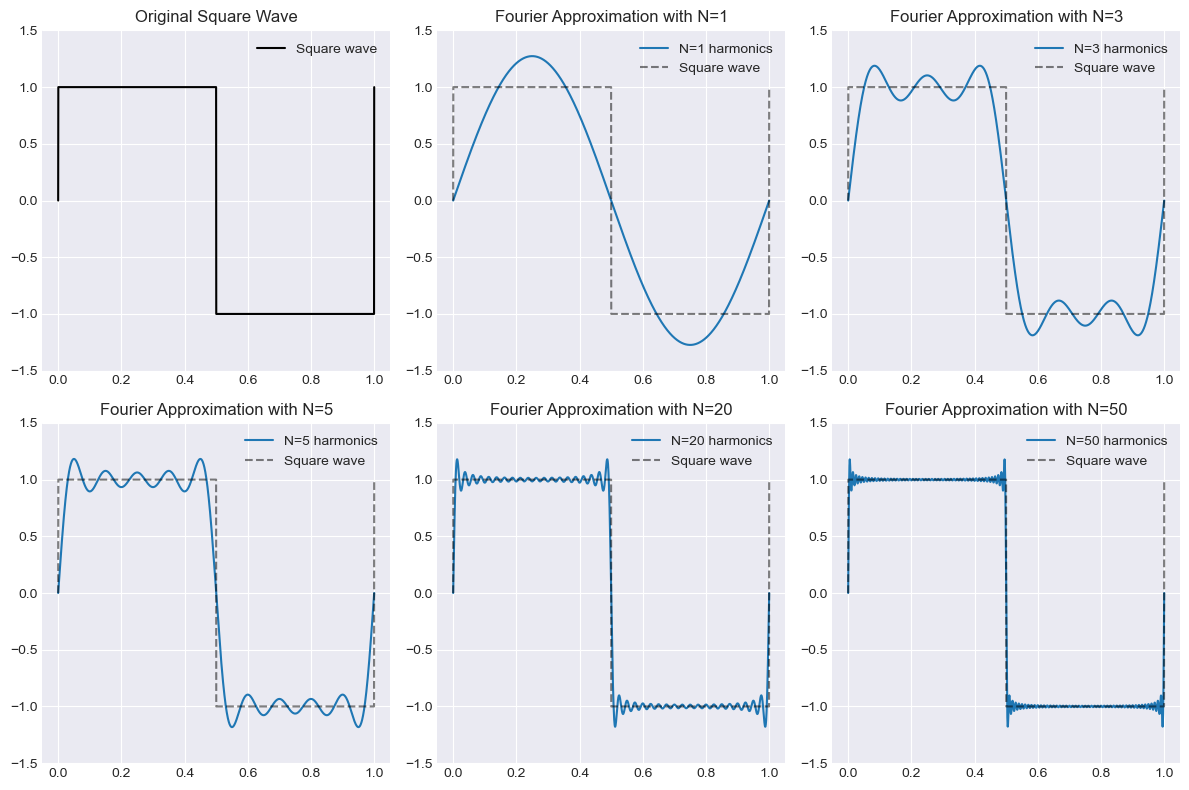

In [14]:
import torch
import matplotlib.pyplot as plt
import time

# Set parameters for the signal
N = 2048 # Number of sample points
T = 1.0 # Duration of the signal in seconds
f0 = 1 # Fundamental frequency of the square wave in Hz

# List of harmonic numbers used to construct the square wave
harmonics = [1, 3, 5, 20, 50]

# Define the square wave function
def square_wave(t):
    return torch.sign(torch.sin(2.0 * torch.pi * f0 * t))

# Fourier series approximation of the square wave
def square_wave_fourier(t, f0, N):
    result = torch.zeros_like(t)
    for k in range(N):
        # The Fourier series of a square wave contains only odd harmonics.
        n = 2 * k + 1
        # Add harmonics to reconstruct the square wave.
        result += torch.sin(2 * torch.pi * n * f0 * t) / n
    # (the sum of the series is pi/4)
    return (4 / torch.pi) * result

# Create the time vector
# np.linspace generates evenly spaced numbers over a specified interval.
# We use endpoint=False because the interval is periodic.
t = torch.linspace(0.0, T, N)

# Generate the original square wave
square = square_wave(t)
plt.figure(figsize=(12, 8))

# Plot the original square wave
plt.subplot(2, 3, 1)
plt.plot(t, square, 'k', label="Square wave")
plt.title("Original Square Wave")
plt.ylim(-1.5, 1.5)
plt.grid(True)
plt.legend()

# Plot Fourier reconstructions under different number of harmonics
for i, Nh in enumerate(harmonics, start=2):
    plt.subplot(2, 3, i)
    y = square_wave_fourier(t, f0, Nh)
    plt.plot(t, y, label=f"N={Nh} harmonics")
    plt.plot(t, square, 'k--', alpha=0.5, label="Square wave")
    plt.title(f"Fourier Approximation with N={Nh}")
    plt.ylim(-1.5, 1.5)
    plt.grid(True)
    plt.legend()
plt.tight_layout()
plt.show()

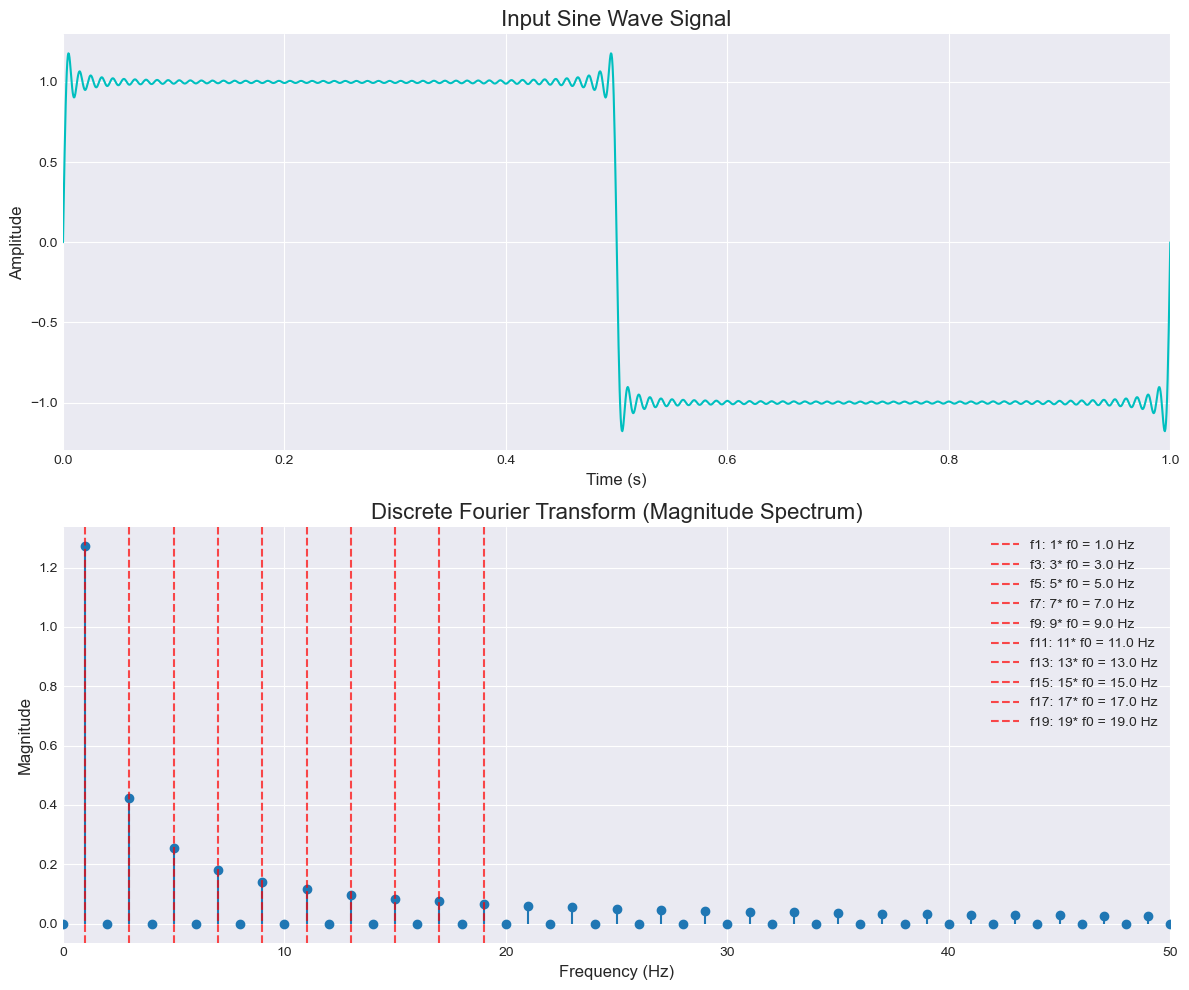

In [ ]:
import torch

def naive_torch_dft(x, device):
    """
    Computes the Discrete Fourier Transform (DFT) of a 1D signal.
    This is a "naïve" implementation that directly follows the DFT formula,
    which has a time complexity of O(N^2).
    Args:
    x (np.ndarray): The input signal, a 1D NumPy array.
    Returns:
    np.ndarray: The complex-valued DFT of the input signal.
    """
    N = len(x)
    # Convert to tensor
    x = torch.tensor(x, dtype=torch.complex64, device=device)
    n = torch.arange(N, dtype=torch.float32, device=device)
    k = n.view(N, 1) 
    # Build DFT matrix and multiply (O(N^2))
    W = torch.exp(-2j * torch.pi * (k @ n.view(1, N)) / N).to(torch.complex64)
    X = W @ x
    return X.detach().cpu().numpy()

N = [32, 2048, 16384]
t = torch.linspace(0.0, T, N)

# Construct a square wave using 50 harmonics
signal = square_wave_fourier(t, f0, 50)

# Time the naïve DFT implementation
start_time_naive = time.time()
dft_result = naive_dft(signal)
end_time_naive = time.time()
naive_duration = end_time_naive - start_time_naive

# Time NumPy's FFT implementation
start_time_fft = time.time()
fft_result = np.fft.fft(signal)
end_time_fft = time.time()
fft_duration = end_time_fft - start_time_fft

# Time Torch DFT implementation
start_time_fft = time.time()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fft_result = naive_torch_dft(y, device)
end_time_fft = time.time()
torch_duration = end_time_fft - start_time_fft

# 3. Print Timings and Verification
print("--- DFT/FFT Performance Comparison ---")
print(f"Naïve DFT Execution Time: {naive_duration:.6f} seconds")
print(f"NumPy FFT Execution Time: {fft_duration:.6f} seconds")

# It's possible for the FFT to be so fast that the duration is 0.0, so we handle that case.
if fft_duration > 0:
    print(f"FFT is approximately {naive_duration / fft_duration:.2f} times faster.")
else:
    print("FFT was too fast to measure a significant duration difference.")

# Check if our implementation is close to NumPy's result
# np.allclose is used for comparing floating-point arrays.
print(f"\nOur DFT implementation is close to NumPy's FFT: {np.allclose(dft_result, fft_result)}")

# Part 2

### Numpy version

In [7]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Extract the meaningful parameters of the faces dataset

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

# It is important in machine learning to split the data accordingly into training and testing sets to
# avoid contamination of the model. Ideally, you should also have a validation set.

# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [19]:
# Center data
mean = np.mean(X_train, axis=0)
X_train -= mean
X_test -= mean

#Eigen-decomposition
U, S, V = np.linalg.svd(X_train, full_matrices=False)
components = V[:n_components]
eigenfaces = components.reshape((n_components, h, w))

#project into PCA subspace
X_transformed = np.dot(X_train, components.T)
print(X_transformed.shape)
X_test_transformed = np.dot(X_test, components.T)
print(X_test_transformed.shape)

(966, 150)
(322, 150)


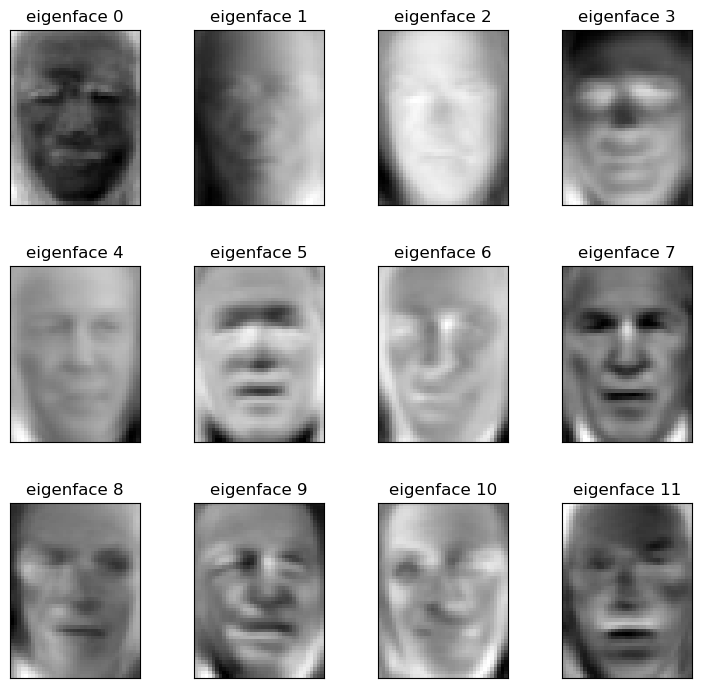

In [21]:
import matplotlib.pyplot as plt
# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

(966,)


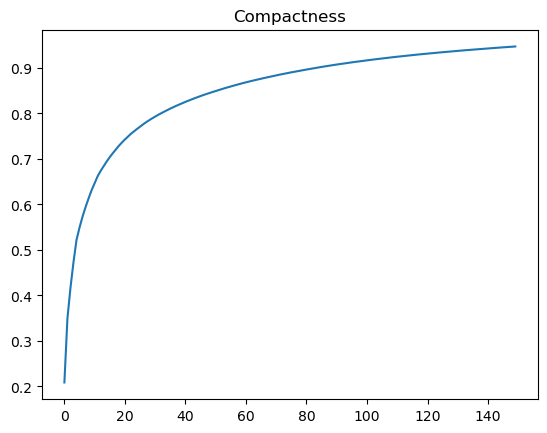

In [10]:
explained_variance = (S ** 2) / (n_samples - 1)
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var
ratio_cumsum = np.cumsum(explained_variance_ratio)
print(ratio_cumsum.shape)
eigenvalueCount = np.arange(n_components)

plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
plt.title('Compactness')
plt.show()

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

#build random forest
estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150)
estimator.fit(X_transformed, y_train) #expects X as [n_samples, n_features]

predictions = estimator.predict(X_test_transformed)
correct = predictions==y_test
total_test = len(X_test_transformed)
#print("Gnd Truth:", y_test)
print("Total Testing", total_test)
print("Predictions", predictions)
print("Which Correct:",correct)
print("Total Correct:",np.sum(correct))
print("Accuracy:",np.sum(correct)/total_test)

print(classification_report(y_test, predictions, target_names=target_names))

Total Testing 322
Predictions [3 3 6 3 3 3 3 1 3 3 3 4 3 3 3 3 6 3 3 4 1 1 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3
 3 3 1 3 1 3 1 1 3 3 3 4 3 3 3 3 3 1 2 1 3 3 3 1 1 3 6 3 5 1 4 1 3 6 6 3 3
 3 2 3 6 3 3 6 3 3 3 3 3 3 3 3 1 3 6 3 3 1 3 1 1 2 6 3 3 3 3 3 3 3 3 3 1 3
 3 6 3 3 3 1 4 1 3 1 3 3 1 3 4 5 3 1 3 6 6 6 3 3 4 3 3 1 3 3 3 3 1 3 3 1 3
 6 1 1 3 1 3 3 3 6 1 3 3 6 5 5 1 3 3 5 1 3 3 3 3 3 1 5 3 3 3 3 5 3 3 1 1 3
 3 3 3 3 2 4 3 2 3 4 3 3 3 3 3 3 3 3 1 5 1 4 2 4 3 1 3 3 3 3 3 3 1 3 3 3 6
 3 1 1 3 3 3 2 3 3 3 3 3 3 1 6 3 3 3 3 4 2 3 3 3 3 3 3 4 3 4 3 4 3 4 3 1 3
 3 3 3 3 1 3 6 6 1 6 1 1 1 3 3 6 3 3 3 3 3 1 1 3 3 3 3 3 3 3 4 3 3 5 3 3 3
 3 6 3 3 3 6 3 3 1 3 3 3 3 3 3 3 1 3 1 3 3 1 3 3 4 3]
Which Correct: [ True  True  True  True  True  True False  True  True  True  True False
  True False  True  True False  True  True  True  True False  True False
 False False False  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False False  True
 False  T

/Users/ryu/miniconda3/envs/COMP3710A2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ryu/miniconda3/envs/COMP3710A2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ryu/miniconda3/envs/COMP3710A2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"

### PyTorch version

In [26]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch

# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Extract the meaningful parameters of the faces dataset

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

# It is important in machine learning to split the data accordingly into training and testing sets to
# avoid contamination of the model. Ideally, you should also have a validation set.

# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test  = torch.tensor(y_test, dtype=torch.long)

# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [31]:
# Center data
mean = torch.mean(X_train, axis=0)
X_train -= mean
X_test -= mean

#Eigen-decomposition
U, S, V = torch.linalg.svd(X_train, full_matrices=False)
components = V[:n_components]
eigenfaces = components.reshape((n_components, h, w))

#project into PCA subspace
X_transformed = torch.matmul(X_train, components.T)
print(X_transformed.shape)
X_test_transformed = torch.matmul(X_test, components.T)
print(X_test_transformed.shape)

torch.Size([966, 150])
torch.Size([322, 150])


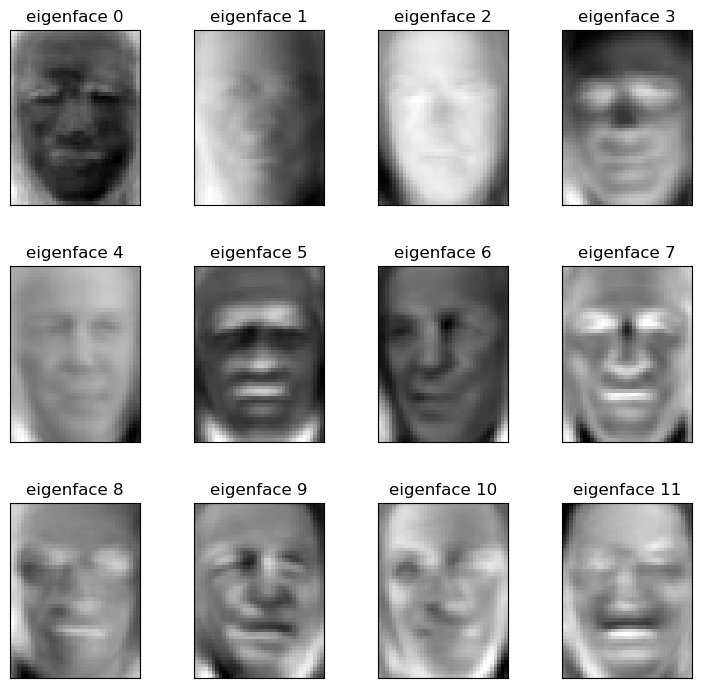

In [32]:
import matplotlib.pyplot as plt
# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

torch.Size([966])


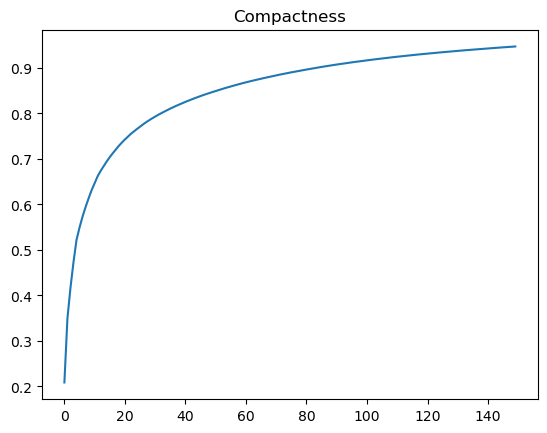

In [34]:
explained_variance = (S ** 2) / (n_samples - 1)
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var
ratio_cumsum = torch.cumsum(explained_variance_ratio, dim=0)
print(ratio_cumsum.shape)
eigenvalueCount = torch.arange(n_components)

plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
plt.title('Compactness')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#build random forest
estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150)
estimator.fit(X_transformed, y_train) #expects X as [n_samples, n_features]

predictions = estimator.predict(X_test_transformed)
correct = predictions==y_test
total_test = len(X_test_transformed)
#print("Gnd Truth:", y_test)
print("Total Testing", total_test)
print("Predictions", predictions)
print("Which Correct:",correct)
print("Total Correct:",torch.sum(correct))
print("Accuracy:",torch.sum(correct)/total_test)

print(classification_report(y_test, predictions, target_names=target_names))

Total Testing 322
Predictions [3 3 6 3 3 3 3 1 3 3 3 3 3 3 3 3 4 3 3 4 1 1 3 3 1 3 4 3 3 3 3 3 3 3 3 3 3
 3 3 1 3 1 3 1 1 3 3 3 4 3 3 3 3 3 1 2 1 3 5 3 1 1 3 4 3 5 3 4 1 2 6 4 3 3
 3 2 3 6 3 3 6 3 3 3 3 3 3 3 3 3 3 6 3 1 1 3 1 1 1 6 3 3 3 3 3 3 3 3 3 1 3
 1 6 3 3 3 3 4 1 3 1 3 3 1 3 4 5 3 1 3 6 6 6 3 3 4 3 3 4 3 3 3 3 1 3 3 3 3
 1 1 1 3 3 3 3 3 3 3 3 3 3 5 5 1 3 3 5 1 3 3 1 3 3 1 5 3 3 3 3 5 3 3 3 1 3
 3 3 3 3 2 4 3 2 3 6 3 3 3 3 3 3 3 3 2 3 1 4 2 4 3 1 5 3 3 3 3 3 1 3 3 3 6
 3 1 2 3 3 3 2 3 3 3 3 3 3 1 1 3 3 3 3 4 3 3 3 3 3 3 3 5 4 4 3 4 3 4 3 1 3
 3 3 3 3 1 3 6 6 1 6 1 6 1 3 3 6 3 3 3 3 3 1 1 3 3 3 1 3 3 3 4 3 3 5 3 3 1
 3 6 3 3 3 6 3 3 1 3 3 3 1 3 3 3 1 3 3 3 3 1 3 3 4 3]
Which Correct: tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True, False,  True,  True, False,  True,  True,  True,
         True, False,  True, False, False, False, False,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  Tr

/Users/ryu/miniconda3/envs/COMP3710A2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ryu/miniconda3/envs/COMP3710A2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ryu/miniconda3/envs/COMP3710A2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"

# Part 3

### Part 3.1 CNN Classifier

In [ ]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
from torch import optim
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Extract the meaningful parameters of the faces dataset

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data.reshape(-1, h, w)

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

# It is important in machine learning to split the data accordingly into training and testing sets to
# avoid contamination of the model. Ideally, you should also have a validation set.

# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test  = torch.tensor(y_test, dtype=torch.long)

# (N, H, W) -> (N, 1, H, W)
X_train = X_train.unsqueeze(1)
X_test  = X_test.unsqueeze(1)

# Create TensorDataset for training and testing
batch_size = 5
train_ds = TensorDataset(X_train, y_train)
test_ds  = TensorDataset(X_test,  y_test)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=True)

In [13]:
class CNN(nn.Module):
   def __init__(self, in_channels, num_classes):

       """
       Building blocks of convolutional neural network.

       Parameters:
           * in_channels: Number of channels in the input image.
           * num_classes: Number of classes to predict.
       """
       super(CNN, self).__init__()

       # 1st convolutional layer
       self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1)
       # Max pooling layer
       self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
       # 2nd convolutional layer
       self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
       # Fully connected layer
       self.fc1 = nn.Linear(32 * 7 * 7, num_classes)
       # Adaptive Average Pooling（7×7）
       self.gap = nn.AdaptiveAvgPool2d((7, 7))

   def forward(self, x):
       """
       Define the forward pass of the neural network.

       Parameters:
           x: Input tensor.

       Returns:
           torch.Tensor
               The output tensor after passing through the network.
       """
       x = F.relu(self.conv1(x))  # Apply first convolution and ReLU activation
       x = self.pool(x)           # Apply max pooling
       x = F.relu(self.conv2(x))  # Apply second convolution and ReLU activation
       x = self.pool(x)           # Apply max pooling
       x = self.gap(x)            # Apply global average pooling
       x = x.reshape(x.shape[0], -1)  # Flatten the tensor
       x = self.fc1(x)            # Apply fully connected layer
       return x

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CNN(in_channels=1, num_classes=n_classes).to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=7, bias=True)
  (gap): AdaptiveAvgPool2d(output_size=(7, 7))
)


In [15]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
num_epochs=10
for epoch in range(num_epochs):
 # Iterate over training batches
   print(f"Epoch [{epoch + 1}/{num_epochs}]")

   for data, targets in train_loader:
       data = data.to(device)
       targets = targets.to(device)
       scores = model(data)
       loss = criterion(scores, targets)
       optimizer.zero_grad()
       loss.backward()
       optimizer.step()

Epoch [1/10]
Epoch [2/10]
Epoch [3/10]
Epoch [4/10]
Epoch [5/10]
Epoch [6/10]
Epoch [7/10]
Epoch [8/10]
Epoch [9/10]
Epoch [10/10]


In [17]:
model.eval()
correct = total = 0
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)
        logits = model(data)
        preds = logits.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)
        
        # Collect predictions and targets for classification report
        all_predictions.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

print(f"Test Accuracy: {correct/total:.3f}")
print("\nDetailed Classification Report:")
print(classification_report(all_targets, all_predictions, target_names=target_names))

Test Accuracy: 0.764

Detailed Classification Report:
                   precision    recall  f1-score   support

     Ariel Sharon       0.69      0.69      0.69        13
     Colin Powell       0.81      0.85      0.83        60
  Donald Rumsfeld       0.62      0.59      0.60        27
    George W Bush       0.77      0.96      0.86       146
Gerhard Schroeder       0.58      0.28      0.38        25
      Hugo Chavez       0.73      0.53      0.62        15
       Tony Blair       0.94      0.42      0.58        36

         accuracy                           0.76       322
        macro avg       0.73      0.62      0.65       322
     weighted avg       0.77      0.76      0.74       322



### Part 3.3 DAWNBench Challenge 

# Part 4